### Get LIF model parameters from Allen SDK

* cell id: 318808427: 'Nr5a1', 395830185: 'Scnna1', 314804042: 'Rorb', 330080937: 'Pvalb', 318331342: 'Pvalb'
* cell type
* tau $\tau= CR$ (ms)
* capacitance $C$ (pF = $10^{-3}$ nF)
* resistent: $1/g_L$ ($R$ is in $M \Omega = 10^6 \Omega$)
* leaky membrane potential $E_L$ (mV)
* reset voltage $V_{reset}$ (mV)
* refractory period $t_{ref}$ (ms)
* firing threshold $V_{th}$ (ms)
* input current $I$ (pA)

#### Neuron dynamics:
* Membrane potential: $\tau \frac{dV}{dt} = -g(V-E_L) + I$ or $\frac{dV}{dt} = -\frac{1}{\tau}(V-E_L) + \frac{1}{C}I$
* Fring: $V>V_{th}$
* Reset: $V=V_{reset}$ as $t<t_{spike} + t_{ref}$

#### List of cells to model
* Nr5a1: 318808427
* Scnna1: 395830185
* Rorb: 314804042
* Pvalb: 330080937
* Pvalb: 318331342

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import json
cellNickName = {318808427: 'Nr5a1', 395830185: 'Scnn1a', 314804042: 'Rorb', 330080937: 'PV1', 318331342: 'PV2'}

In [2]:
LIFModelDF = np.load('LIFModel.npy')

### Get Neuronal information in V1 Layer 4

In [3]:
cellData = pd.read_csv('V1_L4.csv', sep=' ', index_col='index')

### Neuronal dynamics -- create an exmaple neuron using NEST-stimulator

In [4]:
import nest
import nest.raster_plot

In [ ]:
# n_cell_type = cellData['type'][0]
# index_array = LIFModelDF['type']==n_cell_type
# neuronparams = { 'tau_m':LIFModelDF[index_array]['tau_m'][0],
#                  'V_th':LIFModelDF[index_array]['V_th'][0],
#                  'E_L':LIFModelDF[index_array]['E_L'][0],
#                  't_ref':LIFModelDF[index_array]['t_ref'][0],
#                  'V_reset':LIFModelDF[index_array]['V_reset'][0],
#                  'C_m':LIFModelDF[index_array]['C_m'][0],
#                  'V_m':LIFModelDF[index_array]['E_L'][0]} #initial membrane potential

In [ ]:
# n_cell = nest.Create('iaf_neuron', 1)
# nest.SetStatus(n_cell, neuronparams)
# nest.SetStatus(n_cell, 'I_e', 300.) #I_e: pA
# multimeter = nest.Create("multimeter")
# nest.SetStatus(multimeter, {"withtime":True, "record_from":["V_m"]})
# spikedetector = nest.Create("spike_detector")
# nest.Connect(multimeter, n_cell)
# nest.Connect(n_cell, spikedetector)
# nest.Simulate(1000.0)
# dmm = nest.GetStatus(multimeter)[0]
# Vms = dmm["events"]["V_m"]
# ts = dmm["events"]["times"]
# fig, ax = plt.subplots()
# ax.plot(ts, Vms)
# dSD = nest.GetStatus(spikedetector,keys='events')[0]
# evs = dSD["senders"]
# ts = dSD["times"]
# ax.plot(ts, np.ones(len(ts))*neuronparams['V_th'], ".")

### External inputs

* Input data: inputs_data/0_spk.dat
* Input for each cell: external_inputs_0_0/cell-(#: __from 0 to 449__).dat
* Dynamics (tw_exc synapse) -- NEURON (__Exp2Syn__): w, e, tau1, tau2, delay
* Dynamics (using exc synapse instead) -- NEST (there is no built-in Exp2Syn in NEST; __Exp1Syn__): w, e, tau2, delay

In [9]:
with open('syn_data.json') as syn_data_file:    
    syn_params = json.load(syn_data_file)

#### number of presynaptic spikes that evokes a postsynaptic spike

| cell ID       | number  |
| ------------- | -------:|
| Scnn1a        | 84      |
| Rorb          | 48      |
| Nr5a1         | 55      |
| PV1           | 33      |
| PV2           | 32      |
| LIF_exc       | 28      |
| LIF_inh       | 125     |

In [5]:
numPreSynSpike = {'Nr5a1': 55, 'Scnn1a': 84, 'Rorb':48, 'PV1':33, 'PV2':32, 'LIF_exc':28, 'LIF_inh':125}

#### Example for a single neuron

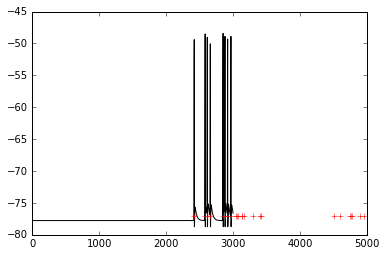

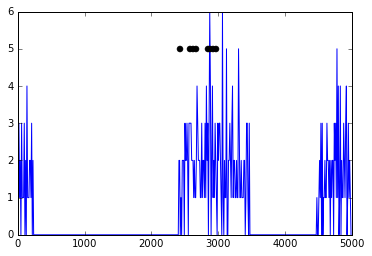

In [78]:
from external_inputs import *

nest.ResetKernel()
nest.SetStatus([0], [{'resolution':0.001}])

cellIndex   = 0
# generate input spike for cell-0
f_ext_in_name = 'external_inputs_0_0/cell-%d.dat' % (cellIndex)
t_stop = 10000.
input_trains = external_inputs(f_ext_in_name, t_stop)
inputs_node = nest.Create("spike_generator", len(input_trains))

input_train_dict = []
for n_node in xrange(len(input_trains)):
    input_train_dict.append({"spike_times": input_trains[n_node]})

nest.SetStatus(inputs_node, input_train_dict)

# Create cell
neuron_node = nest.Create('iaf_cond_exp', 1)
n_cell_type = cellData['type'][cellIndex]
index_array = LIFModelDF['type']==n_cell_type
neuronparams = { 'g_L':LIFModelDF[index_array]['C_m'][0]/LIFModelDF[index_array]['tau_m'][0],
                 'V_th':LIFModelDF[index_array]['V_th'][0],
                 'E_L':LIFModelDF[index_array]['E_L'][0],
                 't_ref':LIFModelDF[index_array]['t_ref'][0],
                 'V_reset':LIFModelDF[index_array]['V_reset'][0],
                 'C_m':LIFModelDF[index_array]['C_m'][0],
                 'V_m':LIFModelDF[index_array]['E_L'][0]} #initial membrane potential
synapseparams = {'E_ex': syn_params[n_cell_type]['exc']['e'],
                 'E_in': syn_params[n_cell_type]['inh']['e'],
                 'tau_syn_ex': syn_params[n_cell_type]['exc']['tau2'],
                 'tau_syn_in': syn_params[n_cell_type]['inh']['tau2']}

nest.SetStatus(neuron_node, neuronparams);
nest.SetStatus(neuron_node, synapseparams);

# monitoring membrane potential of cell
multimeter = nest.Create("multimeter")
spikedetector = nest.Create("spike_detector")

nest.SetStatus(multimeter, {"withtime":True, "record_from":["V_m", "g_ex", "g_in"]})
# nest.SetStatus(spikedetector, {"precise_times":True})

# connection
# nest.Connect([inputs_node[cellIndex]], neuron_node, 'all_to_all', 
#              {"weight": syn_params[n_cell_type]['tw_exc']['w']*1000., 
#               "delay": syn_params[n_cell_type]['tw_exc']['delay']})

tw_exc_weight = (neuronparams['V_th']-neuronparams['V_reset'])/numPreSynSpike[n_cell_type]/(synapseparams['E_ex']-neuronparams['V_reset'])*neuronparams['C_m']*50.

nest.Connect([inputs_node[0]], neuron_node, 'all_to_all', 
             {"weight": tw_exc_weight,
              "delay": syn_params[n_cell_type]['tw_exc']['delay']})


nest.Connect(multimeter, neuron_node)
nest.Connect(neuron_node, spikedetector)

# simulation
nest.Simulate(3000.)

dmm = nest.GetStatus(multimeter)[0]
Vms = dmm["events"]["V_m"]
ts = dmm["events"]["times"]
# g_exs = dmm["events"]["g_ex"]
# g_ins = dmm["events"]["g_in"]

fig, ax = plt.subplots()
ax.plot(ts-ts.min(), Vms,'-k',label='Vm')
ax.plot(input_trains[0], np.ones(len(input_trains[0]))*-77.,'+r',label='Input spike')
# # ax.legend()
# # ax.set_ylim([-78.0, -76.9])
# # ax.set_xlim([2412., 2430.])

# fig, ax = plt.subplots()
# ax.plot(ts-ts.min(), Vms,'-k',label='Vm')
# ax.plot(input_trains[0], np.ones(len(input_trains[0]))*neuronparams['V_th'],'+r',label='Input spike')
# # ax.legend()

# # fig, ax = plt.subplots()
# # ax.plot(ts-ts.min(), g_exs,'-b',label='g_ex')
# # ax.plot(ts-ts.min(), g_ins,'-r',label='g_in')
# # ax.legend()


dSD = nest.GetStatus(spikedetector,keys='events')[0]
evs = dSD["senders"]
ts = dSD["times"]
# ax.plot(ts, np.ones(len(ts))*neuronparams['V_th'], ".")

# fig, ax = plt.subplots()
# ax.plot(g_exs*(-Vms)/neuronparams['C_m'])
# # ax.plot(ts, np.ones(len(ts))*neuronparams['V_th'], ".")
# ax.plot(input_trains[0], np.ones(len(input_trains[0])),'+r',label='Input spike')

input_trains_list = []
for input_train in input_trains:
    input_trains_list.extend(input_train)

hist, bin_edges = np.histogram(input_trains_list, bins = np.arange(0, 5000, 10))
max_hist = hist.max() - 1
fig, ax = plt.subplots()
ax.plot(bin_edges[:-1], hist)
ax.plot(ts, np.ones(len(ts))*max_hist,'ok')

#### Example for all neurons

In [ ]:
# from external_inputs import *

# nest.ResetKernel()
# nest.SetStatus([0], [{'resolution':0.001}])

# neuron_node = nest.Create('iaf_cond_exp', len(cellData))
# multimeter = nest.Create("multimeter", len(cellData))
# nest.SetStatus(multimeter, {"withtime":True, "record_from":["V_m", "g_ex", "g_in"]})
# nest.Connect(multimeter, neuron_node, 'one_to_one')

# t_stop = 5000.

# inputs_node_list = [];

# for ncell in xrange(len(cellData)):
#     f_ext_in_name = 'external_inputs_0_0/cell-%d.dat' % (ncell)
#     input_trains = external_inputs(f_ext_in_name, t_stop)
#     inputs_node = nest.Create("spike_generator", len(input_trains))
#     input_train_dict = []
#     for n_node in xrange(len(input_trains)):
#         input_train_dict.append({"spike_times": input_trains[n_node]})

#     nest.SetStatus(inputs_node, input_train_dict)
#     inputs_node_list.append(inputs_node)

#     n_cell_type = cellData['type'][0]
#     index_array = LIFModelDF['type']==n_cell_type
#     neuronparams = { 'g_L':LIFModelDF[index_array]['C_m'][0]/LIFModelDF[index_array]['tau_m'][0],
#                      'V_th':LIFModelDF[index_array]['V_th'][0],
#                      'E_L':LIFModelDF[index_array]['E_L'][0],
#                      't_ref':LIFModelDF[index_array]['t_ref'][0],
#                      'V_reset':LIFModelDF[index_array]['V_reset'][0],
#                      'C_m':LIFModelDF[index_array]['C_m'][0],
#                      'V_m':LIFModelDF[index_array]['E_L'][0]} #initial membrane potential
#     synapseparams = {'E_ex': syn_params[n_cell_type]['exc']['e'],
#                      'E_in': syn_params[n_cell_type]['inh']['e'],
#                      'tau_syn_ex': syn_params[n_cell_type]['exc']['tau2'],
#                      'tau_syn_in': syn_params[n_cell_type]['inh']['tau2']}
#     nest.SetStatus([neuron_node[ncell]], neuronparams);
#     nest.SetStatus([neuron_node[ncell]], synapseparams);

#     nest.Connect(inputs_node_list[ncell], [neuron_node[ncell]], 'all_to_all', 
#                  {"weight": syn_params[n_cell_type]['tw_exc']['w']*1000., 
#                   "delay": syn_params[n_cell_type]['tw_exc']['delay']})
    

# # simulation
# nest.Simulate(t_stop)

In [ ]:
# dmm = nest.GetStatus(multimeter)[0]
# Vms = dmm["events"]["V_m"]
# ts = dmm["events"]["times"]
# g_exs = dmm["events"]["g_ex"]
# g_ins = dmm["events"]["g_in"]

# fig, ax = plt.subplots()
# ax.plot(ts-ts.min(), Vms,'-k',label='Vm')

### Synaptic dynamics